# Comparison of graphs $G(v,e)$ with set of edges $E$ to graphs $g(v,e)$ with set of edges $e$. 


In [11]:
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

import cartopy.crs as ccrs
import matplotlib.ticker as mticker

fontsize = 26

pgf_with_latex = {  # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",  # change this if using xetex or lautex
    "text.usetex": True,  # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],  # blank entries should cause plots
    "font.sans-serif": [],  # to inherit fonts from the document
    "font.monospace": [],
    "axes.labelsize": fontsize,  # LaTeX default is 10pt font.
    "font.size": fontsize,
    "legend.fontsize": fontsize,  # Make the legend/label fonts
    "xtick.labelsize": fontsize,  # a little smaller
    "ytick.labelsize": fontsize,
    "figure.figsize": (12, 8),  # default fig size of 0.9 textwidth
    "pgf.preamble": "\n".join(
        [  # plots will use this preamble
            r"\usepackage[utf8]{inputenc}",
            r"\usepackage[T1]{fontenc}",
        ]
    ),
}

mpl.rcParams.update(pgf_with_latex)


import src.RoadNetwork as rn


In [7]:
def get_location_shape(location_name):
    """
    Returns the shape of a location in a geopandas dataframe with coordinate reference system epsg:4326.

    Args:
        location_name (str): The name of the location for which to retrieve the shape.

    Returns:
        A geopandas dataframe representing the shape of the location in epsg:4326 coordinate reference system.
    """
    # Use the geopandas library to retrieve the shape of the location
    shape = gpd.read_file(
        f"https://nominatim.openstreetmap.org/search.php?q={location_name}&polygon_geojson=1&format=geojson"
    )

    admin_boundary = shape[shape["type"] == "administrative"]

    # Set the coordinate reference system of the shape to epsg:4326
    admin_boundary = admin_boundary.to_crs("epsg:4326")

    return admin_boundary


def generate_random_bounding_box(area, location_gdf):
    """
    Generates a random bounding box within a given area and a reference geometry.

    Args:
        area (float): The desired area of the bounding box.
        location_gdf (geopandas.GeoDataFrame): A GeoDataFrame representing the reference geometry.

    Returns:
        tuple: A tuple containing the north, south, west, and east coordinates of the generated bounding box.
    """
    # Bounding box limits for Germany
    bounding_box = location_gdf.total_bounds

    # Calculate latitude and longitude differences based on the area
    latitude_diff = bounding_box[3] - bounding_box[1]
    longitude_diff = bounding_box[2] - bounding_box[0]

    while True:
        # Calculate the size of the bounding box based on the area
        box_width = area**0.5  # Square root of area
        box_height = area / box_width

        # Calculate random coordinates within the bounding box
        north = bounding_box[3] - random.uniform(0, latitude_diff - box_height)
        south = north - box_height
        east = bounding_box[0] + random.uniform(0, longitude_diff - box_width)
        west = east + box_width

        # Create a polygon from the generated coordinates
        bbox_polygon = Polygon(
            [(west, south), (east, south), (east, north), (west, north)]
        )

        # Check if the generated bounding box is within Germany
        if location_gdf.intersects(bbox_polygon).any():
            return north, south, west, east


### Possible OSM highway tags. Comparing to significant tags, corresponding to set of edges $E$.

In [8]:
all_highway_tags = [
    "motorway",
    "trunk",
    "primary",
    "secondary",
    "tertiary",
    "motorway_link",
    "trunk_link",
    "primary_link",
    "secondary_link",
    "tertiary_link",
    "unclassified",
    "residential",
]

significant_highway_tags = [
    "motorway",
    "trunk",
    "primary",
    "secondary",
    "tertiary",
    "motorway_link",
    "trunk_link",
    "primary_link",
    "secondary_link",
    "tertiary_link",
]


### Creating randomly chosen ares within Germany and to create RoadNetworks. We have provided a DataFrame with pre-set regions, such that the results are compareable. You can unmark the code to genearte your own DataFrame.

In [9]:
"""germany_gdf = get_location_shape("Germany")

area_sizes = np.logspace(np.log10(0.03), np.log10(0.06), num=5)
bboxs = []

for area_size in area_sizes:
    for i in range(0, 25):
        north, south, east, west = generate_random_bounding_box(area_size, germany_gdf)
        bboxs.append([north, south, east, west])
bboxs_arr = np.array(bboxs)

pd.DataFrame(bboxs_arr, columns=["north", "south", "east", "west"]).to_csv(
    "data/random-bboxes-in-GER.csv"
)
"""


'germany_gdf = get_location_shape("Germany")\n\narea_sizes = np.logspace(np.log10(0.03), np.log10(0.06), num=5)\nbboxs = []\n\nfor area_size in area_sizes:\n    for i in range(0, 25):\n        north, south, east, west = generate_random_bounding_box(area_size, germany_gdf)\n        bboxs.append([north, south, east, west])\nbboxs_arr = np.array(bboxs)\n\npd.DataFrame(bboxs_arr, columns=["north", "south", "east", "west"]).to_csv(\n    "data/random-bboxes-in-GER.csv"\n)\n'

### Computing the loads (pre-calculated) and comparing graphs with different edge sets to each other. 

In [10]:
germany_gdf = get_location_shape("Germany")

area_sizes = np.logspace(np.log10(0.03), np.log10(0.06), num=5)

node_share_arr = []
edge_share_arr = []
commuter_share_arr = []

bboxes = pd.read_csv("data/random-bboxes-in-GER.csv", index_col=0)

for i, bbox in bboxes.iterrows():
    try:
        north, south, east, west = (
            bbox["north"],
            bbox["south"],
            bbox["east"],
            bbox["west"],
        )

        region = rn.RoadNetwork(
            osmpbf="germany.osm.pbf",
            highway_filter=f"w/highway={','.join(all_highway_tags)}",
            bbox=[north, south, west, east],
        )
        region.loads("travel_time", cpu_cores=5)

        region_small = rn.RoadNetwork(
            osmpbf="germany.osm.pbf",
            highway_filter=f"w/highway={','.join(significant_highway_tags)}",
            bbox=[north, south, west, east],
        )
        region_small.loads("travel_time", cpu_cores=5)

        nodes, edges = region.nodes, region.edges
        nodes_small, edges_small = region_small.nodes, region_small.edges

        significant_edges = edges[
            edges["highway"]
            .astype(str)
            .str.contains("|".join(significant_highway_tags))
        ]

        commuters_on_signifcant_roads = (
            significant_edges["load"].sum() / edges["load"].sum()
        )

        commuter_share_arr.append(commuters_on_signifcant_roads)
        node_share_arr.append(len(nodes_small) / len(nodes))
        edge_share_arr.append(len(edges_small) / len(edges))
    except:
        print(bbox)


num(nodes)= 2718
num(edges)= 6638
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 169
num(edges)= 348
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 3915
num(edges)= 9388
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 488
num(edges)= 986
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 1916
num(edges)= 4731
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 148
num(edges)= 330
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 911
num(edges)= 2088
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 109
num(edges)= 191
The SIBC has already been computed and stored. Providing the stored values.


/var/folders/c2/7dvwdvpn4xx3ch9f74c148400000gn/T/ipykernel_69453/7757441.py:44: RuntimeWarning: invalid value encountered in scalar divide
  significant_edges["load"].sum() / edges["load"].sum()


num(nodes)= 1654
num(edges)= 3949
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 93
num(edges)= 193
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 293
num(edges)= 668
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 51
num(edges)= 79
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 3399
num(edges)= 8437
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 396
num(edges)= 806
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 608
num(edges)= 1457
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 47
num(edges)= 108
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 924
num(edges)= 2263
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 93
num(edges)=

/var/folders/c2/7dvwdvpn4xx3ch9f74c148400000gn/T/ipykernel_69453/7757441.py:44: RuntimeWarning: invalid value encountered in scalar divide
  significant_edges["load"].sum() / edges["load"].sum()


num(nodes)= 3281
num(edges)= 7784
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 220
num(edges)= 477
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 1299
num(edges)= 3104
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 121
num(edges)= 247
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 1512
num(edges)= 3700
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 165
num(edges)= 350
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 8249
num(edges)= 20298
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 747
num(edges)= 1459
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 1785
num(edges)= 4326
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 144


/var/folders/c2/7dvwdvpn4xx3ch9f74c148400000gn/T/ipykernel_69453/7757441.py:44: RuntimeWarning: invalid value encountered in scalar divide
  significant_edges["load"].sum() / edges["load"].sum()


num(nodes)= 260
num(edges)= 620
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 28
num(edges)= 55
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 3500
num(edges)= 8711
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 332
num(edges)= 734
The SIBC has already been computed and stored. Providing the stored values.
north    54.703722
south    54.479103
east     14.019523
west     13.794903
Name: 76, dtype: float64
num(nodes)= 546
num(edges)= 1323
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 38
num(edges)= 87
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 828
num(edges)= 1998
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 45
num(edges)= 88
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 1648
num(edges)= 4105
The

/var/folders/c2/7dvwdvpn4xx3ch9f74c148400000gn/T/ipykernel_69453/7757441.py:44: RuntimeWarning: invalid value encountered in scalar divide
  significant_edges["load"].sum() / edges["load"].sum()


The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 333
num(edges)= 645
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 1614
num(edges)= 3758
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 184
num(edges)= 336
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 5196
num(edges)= 12813
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 537
num(edges)= 1092
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 3735
num(edges)= 9258
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 492
num(edges)= 979
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 4272
num(edges)= 10225
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 364
num(edges)= 767
The SIBC has alre

/var/folders/c2/7dvwdvpn4xx3ch9f74c148400000gn/T/ipykernel_69453/7757441.py:44: RuntimeWarning: invalid value encountered in scalar divide
  significant_edges["load"].sum() / edges["load"].sum()


num(nodes)= 4873
num(edges)= 11900
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 534
num(edges)= 1047
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 2190
num(edges)= 5611
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 111
num(edges)= 279
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 2984
num(edges)= 7069
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 231
num(edges)= 484
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 2384
num(edges)= 5891
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 146
num(edges)= 314
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 611
num(edges)= 1475
The SIBC has already been computed and stored. Providing the stored values.
num(nodes)= 37
nu

### Creating sample RoadNetwork to show the effect on the load when creating the graphs from different edge sets.

In [13]:
crs = ccrs.GOOGLE_MERCATOR
crs_proj4 = crs.proj4_init


north, south, west, east = [50.2, 50.0, 7, 7.4]


region = rn.RoadNetwork(
    osmpbf="germany.osm.pbf",
    highway_filter=f"w/highway={','.join(all_highway_tags)}",
    bbox=[north, south, west, east],
)

region_small = rn.RoadNetwork(
    osmpbf="germany.osm.pbf",
    highway_filter=f"w/highway={','.join(significant_highway_tags)}",
    bbox=[north, south, west, east],
)
for a in [region, region_small]:
    a.loads("travel_time")

nodes, edges = region.nodes, region.edges
nodes_small, edges_small = region_small.nodes, region_small.edges


num(nodes)= 3610
num(edges)= 9240
num(nodes)= 423
num(edges)= 909
The SIBC has already been computed and stored. Providing the stored values.
The SIBC has already been computed and stored. Providing the stored values.


### Creating significant and insiginficant edge set (wrt load values), depending on the respective OSM tags

In [15]:
significant_edges = edges[
    edges["highway"].astype(str).str.contains("|".join(significant_highway_tags))
]

# significant_edges["load"].sum() / edges["load"].sum()

insignificant_edges = edges[
    ~edges["highway"].astype(str).str.contains("|".join(significant_highway_tags))
]


/Users/jonas/miniconda3/envs/op311/lib/python3.11/site-packages/geopandas/plotting.py:957: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.draw()
/Users/jonas/miniconda3/envs/op311/lib/python3.11/site-packages/geopandas/plotting.py:957: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.draw()
/Users/jonas/miniconda3/envs/op311/lib/python3.11/site-packages/geopandas/plotting.py:957: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.draw()


Text(0.5, 1.0, '$L_{\\ell}$')

/Users/jonas/miniconda3/envs/op311/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/Users/jonas/miniconda3/envs/op311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


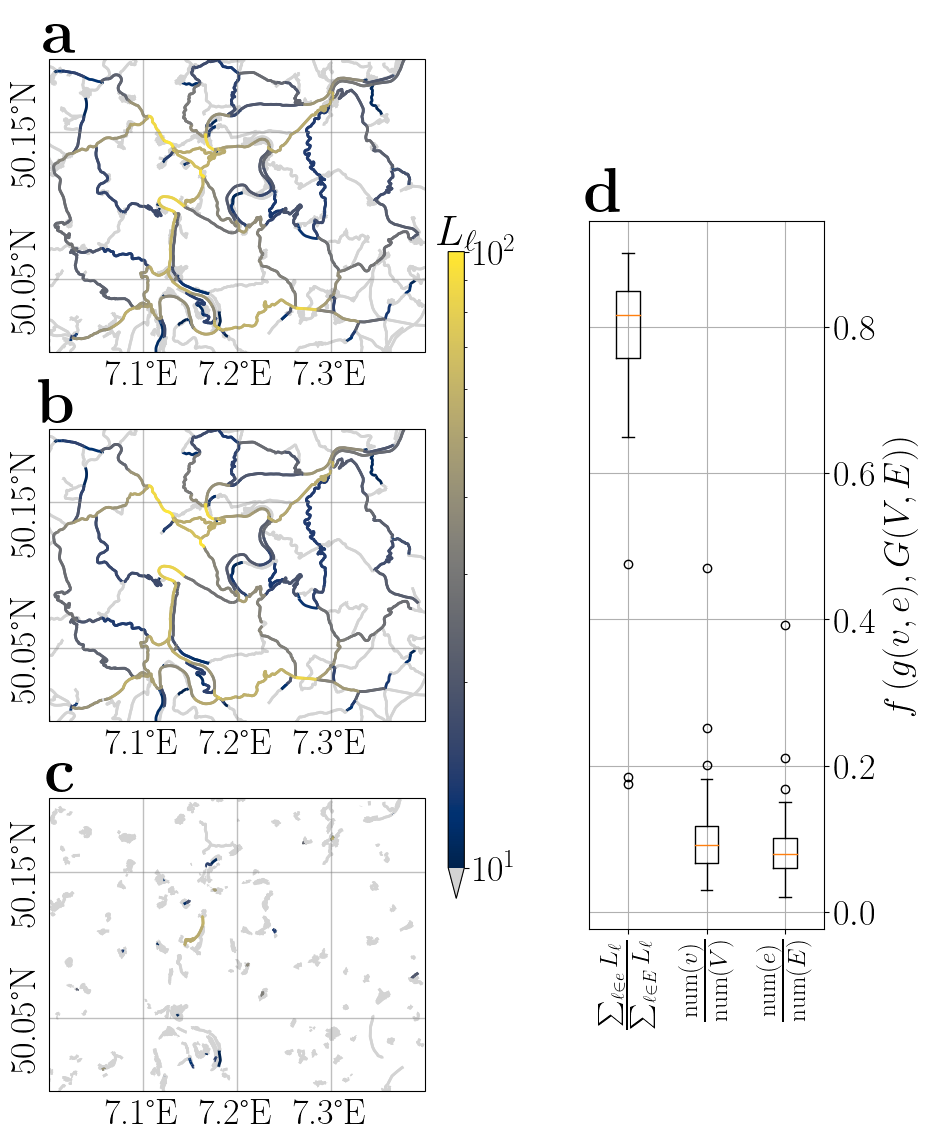

In [16]:
fig = plt.figure(figsize=(10, 14), layout="constrained")

gs = mpl.gridspec.GridSpec(6, 2, width_ratios=[1, 0.5])

ax0 = fig.add_subplot(gs[0:2, 0:1], projection=crs)
ax1 = fig.add_subplot(gs[2:4, 0:1], projection=crs)
ax2 = fig.add_subplot(gs[4:6, 0:1], projection=crs)
ax = fig.add_subplot(gs[1:5, 1:2])


panel_labels = [r"\textbf{a}", r"\textbf{b}", r"\textbf{c}"]
ax.text(
    0.15,
    1.075,
    r"\textbf{d}",
    transform=ax.transAxes,
    fontweight="bold",
    fontsize=45,
    va="top",
    ha="right",
)

for i, a in enumerate([ax0, ax1, ax2]):
    a.text(
        0.075,
        1.17,
        panel_labels[i],
        transform=a.transAxes,
        fontweight="bold",
        fontsize=45,
        va="top",
        ha="right",
    )

ax.boxplot(
    [
        np.array(commuter_share_arr)[~np.isnan(commuter_share_arr)],
        node_share_arr,
        edge_share_arr,
    ]
)
ax.grid()
ax.set_xticklabels(
    [
        r"$ \frac{\sum_{\ell \in e }L_{\ell}}{\sum_{\ell \in E}L_{\ell}}$",
        r"$\frac{\mathrm{num}(v)}{\mathrm{num}(V)}$",
        r"$\frac{\mathrm{num}(e)}{\mathrm{num}(E)}$",
    ]
)
ax.set_ylabel(r"$ f \left( g(v, e), G(V, E) \right)$")
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha="center")

##############################################

cmap = plt.get_cmap("cividis")

cmap.set_under("lightgrey")

norm = mpl.colors.LogNorm(vmin=1e1, vmax=max(edges["load"]))
scalar_mapper = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

edges.sort_values(by="load").to_crs(crs_proj4).plot(
    column="load",
    ax=ax0,
    cmap=cmap,
    norm=norm,
    linewidth=2,
)
significant_edges.sort_values(by="load").to_crs(crs_proj4).plot(
    column="load",
    ax=ax1,
    cmap=cmap,
    norm=norm,
    linewidth=2,
)

insignificant_edges.sort_values(by="load").to_crs(crs_proj4).plot(
    column="load",
    ax=ax2,
    cmap=cmap,
    norm=norm,
    linewidth=2,
)

for a in [ax0, ax1, ax2]:
    a.set_extent([west, east, south, north], crs=ccrs.PlateCarree())
    gl = a.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels={"bottom": "x", "left": "y"},
        linewidth=1,
        color="gray",
        alpha=0.5,
        linestyle="-",
    )
    gl.xlocator = mticker.FixedLocator([7, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6])
    gl.ylocator = mticker.FixedLocator(
        [
            50.05,
            50.15,
        ]
    )

    gl.ylabel_style = {"rotation": 90}

cbar = fig.colorbar(
    scalar_mapper, ax=[ax0, ax1, ax2], shrink=0.6, extend="min", aspect=40
)
cbar.ax.set_title(r"$L_{\ell}$")


In [109]:
fig.savefig("results/figs/FIG8-Graph-comparisson.pdf", bbox_inches="tight")
